In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: TkAgg


# Lab 9
### Ian Eykamp

We measured the steady-state output voltage, peak current, and input current of the flyback converter when we swept the V_COMP voltage with an Analog Discovery 2.

V_F for UC2844 = 0.596V
-----
Equations of Linear Fits:
Output Voltage = 8.47 * V_COMP - 9.79V
Peak Current = 6.31℧ * V_COMP - 7.2A
Input Current = 1.63℧ * V_COMP - 2.42A


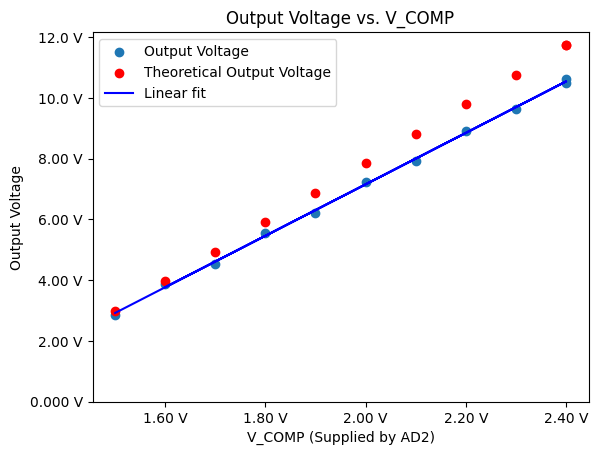

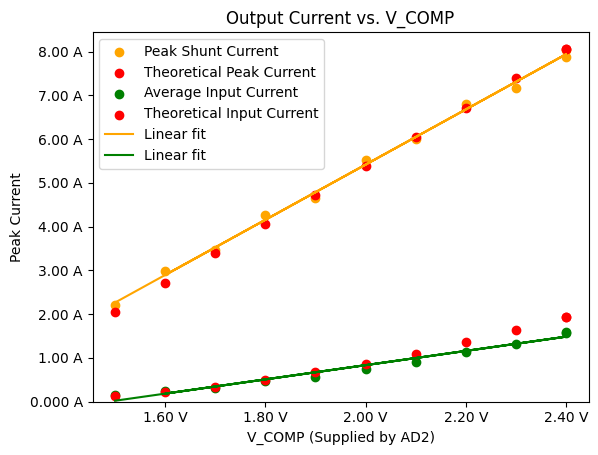

In [230]:
Rload = 5 # Ohms
Rshunt = 0.05 # Ohms
lab9_data = pd.read_csv("Lab_9_input_output_voltage.csv")
lab9_data["Peak Current (A)"] = lab9_data["Peak Vshunt (mV)"] / 1000 / Rshunt

Vf_uc2844 = 0.596 # V
lab9_data["V_Isense_thresh"] = (lab9_data["AD2 Voltage (V)"] - 2 * Vf_uc2844) / 3
lab9_data["Theoretical Peak Current (A)"] = lab9_data["V_Isense_thresh"] / Rshunt
# print(lab9_data.loc[:, ["AD2 Voltage (V)", "Peak Current (A)", "Theoretical Peak Current (A)"]])

alpha = 1.1 # L / Lcrit
Vin = 18 # V
Lm = 16.96e-6 # H
Fs = 50e3 # Hz
Ts = 1 / Fs
K = 2 / Ts * Lm / Rload# * 1.2 # factor of 1.2 applied to make it fit better
# lab9_data["Theoretical Output Voltage (V)"] = (-1 + np.sqrt(1 - 4 * (1 / Vin) * (np.sqrt(alpha) / 2 * lab9_data["Theoretical Peak Current (A)"] * Rload))) / (2 / Vin)
lab9_data["Duty Cycle (%)"] = lab9_data["Theoretical Peak Current (A)"] * Lm / Vin / Ts # percent
lab9_data["Theoretical Output Voltage (V)"] = lab9_data["Theoretical Peak Current (A)"] / np.sqrt(K) * Lm / Ts
# lab9_data["Theoretical Output Voltage (V)"] = (lab9_data["Duty Cycle (%)"] / np.sqrt(alpha)) / (1 - lab9_data["Duty Cycle (%)"] / np.sqrt(alpha)) * Vin
lab9_data["Theoretical Output Current (A)"] = lab9_data["Theoretical Output Voltage (V)"] / Rload
lab9_data["Theoretical Output Power (W)"] = lab9_data["Theoretical Output Current (A)"] * lab9_data["Theoretical Output Voltage (V)"]
lab9_data["Theoretical Input Power (W)"] = lab9_data["Theoretical Output Power (W)"] / (78.6 / 100) # efficiency
lab9_data["Theoretical Input Current (A)"] = lab9_data["Theoretical Input Power (W)"] / Vin
# print(lab9_data.loc[:, ["AD2 Voltage (V)", "Peak Current (A)", "Theoretical Peak Current (A)", "Duty Cycle (%)", "Output Voltage (V)", "Theoretical Output Voltage (V)"]])

plt.figure()
helper.axes_labels("V_COMP (Supplied by AD2)", "V", "Output Voltage", "V", title = "Output Voltage vs. V_COMP")
plt.scatter(lab9_data["AD2 Voltage (V)"], lab9_data["Output Voltage (V)"], label = "Output Voltage")
plt.scatter(lab9_data["AD2 Voltage (V)"], lab9_data["Theoretical Output Voltage (V)"], color = "red", label = "Theoretical Output Voltage")

x = lab9_data["AD2 Voltage (V)"]
y = lab9_data["Output Voltage (V)"]
A = np.vstack([x, np.ones(len(x))]).T
a, b = np.linalg.lstsq(A, y, rcond=None)[0]
plt.plot(lab9_data["AD2 Voltage (V)"], lab9_data["AD2 Voltage (V)"] * a + b, linestyle = "solid", color = "blue", label = "Linear fit")
plt.ylim(bottom = 0)
plt.legend(loc = "upper left")
output_voltage_offset = b
output_voltage_gain = a

plt.figure()
helper.axes_labels("V_COMP (Supplied by AD2)", "V", "Peak Current", "A", title = "Output Current vs. V_COMP")
plt.scatter(lab9_data["AD2 Voltage (V)"], lab9_data["Peak Current (A)"], color = "orange", label = "Peak Shunt Current")
plt.scatter(lab9_data["AD2 Voltage (V)"], lab9_data["Theoretical Peak Current (A)"], color = "red", label = "Theoretical Peak Current")
plt.scatter(lab9_data["AD2 Voltage (V)"], lab9_data["Input Current (A)"], color = "green", label = "Average Input Current")
plt.scatter(lab9_data["AD2 Voltage (V)"], lab9_data["Theoretical Input Current (A)"], color = "red", label = "Theoretical Input Current")
plt.ylim(bottom = 0)

# Peak Current
x = lab9_data["AD2 Voltage (V)"]
y = lab9_data["Peak Current (A)"]
A = np.vstack([x, np.ones(len(x))]).T
a, b = np.linalg.lstsq(A, y, rcond=None)[0]
plt.plot(lab9_data["AD2 Voltage (V)"], lab9_data["AD2 Voltage (V)"] * a + b, linestyle = "solid", color = "orange", label = "Linear fit")
output_current_offset = b
output_current_transconductance_gain = a

# Input Current
x = lab9_data["AD2 Voltage (V)"]
y = lab9_data["Input Current (A)"]
A = np.vstack([x, np.ones(len(x))]).T
a, b = np.linalg.lstsq(A, y, rcond=None)[0]
plt.plot(lab9_data["AD2 Voltage (V)"], lab9_data["AD2 Voltage (V)"] * a + b, linestyle = "solid", color = "green", label = "Linear fit")
input_current_offset = b
input_current_transconductance_gain = a
plt.legend(loc = "upper left")

print(f"V_F for UC2844 = {Vf_uc2844}V")
print("-----")
print("Equations of Linear Fits:")
print(f"Output Voltage = {np.round(output_voltage_gain, 2)} * V_COMP {'+' if output_voltage_offset > 0 else '-'} {abs(np.round(output_voltage_offset, 2))}V")
print(f"Peak Current = {np.round(output_current_transconductance_gain, 2)}℧ * V_COMP {'+' if output_current_offset > 0 else '-'} {abs(np.round(output_current_offset, 2))}A")
print(f"Input Current = {np.round(input_current_transconductance_gain, 2)}℧ * V_COMP {'+' if input_current_offset > 0 else '-'} {abs(np.round(input_current_offset, 2))}A")

The output voltage, peak current, and input current are all linearly dependent on the V_COMP pin voltage with significant gain. This is expected, because internally, the COMP voltage is transformed compared with the shunt voltage; when the shunt current exceeds the transformed COMP voltage, the MOSFET is turned off, and that is the value of the peak current.

The transformation is given by the block diagram from the datasheet and involves a voltage drop of $2 V_F$ and a voltage division of $\frac{1}{3}$. Assuming a voltage drop over each diode of $V_F = 0.596V$ (chosen by trial and error to make the equation fit the data), this yields a theoretical peak current of $I_{peak} = \frac{1}{3} (V_{COMP} - 2 \cdot 0.596 V)$, which matches the observed peak current very closely.

![UC844 Block Diagram](uc2844_block_diagram.png)

After verifying the peak current, I calculated the output voltage using the equation $I_{peak} = \sqrt{K} \cdot T_s \cdot \frac{V_{out}}{L_m}$ from Lesson 8a to solve for $V_{out}$, where $K = \frac{2}{T_s} \cdot \frac{L_m}{R_{load}}$. Assuming the output power $P_{out} = \frac{{V_{out}}^2}{R_{load}}$ matches the input power $P_{in} = V_{in} I_{in}$ scaled by an efficiency of $\eta = 78.6\%$ (measured in Lab 8), then the input current can also be calculated as $I_{in} = \frac{{V_{out}}^2}{V_{in} \cdot R_{load} \cdot \eta}$.

This all yields peak current, output voltage, and input current values that match relatively closely to the observed values. The linear behavior is readily apparent, and the slopes are similar enough to be plausible; however, near the higher V_COMP values, the output voltage differs from the theoretical by more than a Volt. Through trial and error, this difference can be almost fully eliminated by adding a factor of 1.2 to the K value or by decreasing the value of the magnetizing inductance in the equation to $L_m = 14\mu H$. However, I am pretty confident in the values used in the equations, so I believe the difference is coming from a non-ideality elsewhere.

## Bode Plots

DC Gain: 18.58dB
That's a factor of 8.49
-----
Using -3dB magnitude crossover
Cutoff frequency for 5V Output: 1397 Hz
Cutoff frequency for 7V Output: 1754 Hz
Cutoff frequency for 10V Output: 2329 Hz
-----
Using -45° phase shift
Cutoff frequency for 5V Output: 1320 Hz
Cutoff frequency for 7V Output: 1565 Hz
Cutoff frequency for 10V Output: 1856 Hz
-----
Phase margin at 0dB
Phase margin for 5V Output: -48°
Phase margin for 7V Output: -49°
Phase margin for 10V Output: -53°


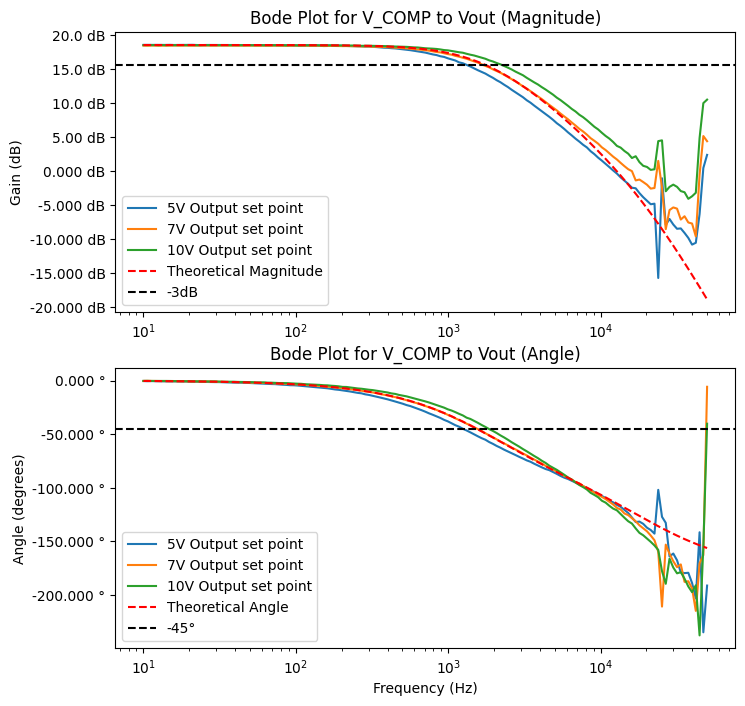

In [231]:
lab9_bode_5V = pd.read_csv("bode_plots/lab9_5Vout.csv", skiprows = 20)
lab9_bode_7V = pd.read_csv("bode_plots/lab9_7Vout.csv", skiprows = 20)
lab9_bode_10V = pd.read_csv("bode_plots/lab9_10Vout.csv", skiprows = 20)
# print(lab9_bode_5V.head())
# print(lab9_bode_7V.head())
# print(lab9_bode_10V.head())

dc_gain_region = (1e1, 1e2)
df_dc_gain = lab9_bode_5V[(lab9_bode_5V["Frequency (Hz)"] > dc_gain_region[0]) & (lab9_bode_5V["Frequency (Hz)"] < dc_gain_region[1])]
dc_gain = np.mean(df_dc_gain["Channel 2 Magnitude (dB)"])
print(f"DC Gain: {round(dc_gain, 2)}dB")
print(f"That's a factor of {round(10**(dc_gain / 20), 2)}")

def find_crossover(x_values, y_values, y_cross_point):
    above_x_values = x_values[y_values < y_cross_point]
    return above_x_values.iloc[0]

print("-----")
print("Using -3dB magnitude crossover")
print(f"Cutoff frequency for 5V Output: {int(find_crossover(lab9_bode_5V['Frequency (Hz)'], lab9_bode_5V['Channel 2 Magnitude (dB)'], dc_gain - 3))} Hz")
print(f"Cutoff frequency for 7V Output: {int(find_crossover(lab9_bode_7V['Frequency (Hz)'], lab9_bode_7V['Channel 2 Magnitude (dB)'], dc_gain - 3))} Hz")
print(f"Cutoff frequency for 10V Output: {int(find_crossover(lab9_bode_10V['Frequency (Hz)'], lab9_bode_10V['Channel 2 Magnitude (dB)'], dc_gain - 3))} Hz")
print("-----")
print("Using -45° phase shift")
print(f"Cutoff frequency for 5V Output: {int(find_crossover(lab9_bode_5V['Frequency (Hz)'], lab9_bode_5V['Channel 2 Phase (deg)'], -45))} Hz")
print(f"Cutoff frequency for 7V Output: {int(find_crossover(lab9_bode_7V['Frequency (Hz)'], lab9_bode_7V['Channel 2 Phase (deg)'], -45))} Hz")
print(f"Cutoff frequency for 10V Output: {int(find_crossover(lab9_bode_10V['Frequency (Hz)'], lab9_bode_10V['Channel 2 Phase (deg)'], -45))} Hz")
print("-----")
print("Phase margin at 0dB")
print(f"Phase margin for 5V Output: {int(find_crossover(lab9_bode_5V['Channel 2 Phase (deg)'], lab9_bode_5V['Channel 2 Magnitude (dB)'], dc_gain - 3))}°")
print(f"Phase margin for 7V Output: {int(find_crossover(lab9_bode_7V['Channel 2 Phase (deg)'], lab9_bode_7V['Channel 2 Magnitude (dB)'], dc_gain - 3))}°")
print(f"Phase margin for 10V Output: {int(find_crossover(lab9_bode_10V['Channel 2 Phase (deg)'], lab9_bode_10V['Channel 2 Magnitude (dB)'], dc_gain - 3))}°")

s = lab9_bode_5V["Frequency (Hz)"] * 1j
G = 1 / ((s / 1.8e3) + 1) / ((s / 2e4) + 1)
theoretical_mag = 20 * np.log10(np.abs(G)) + dc_gain
theoretical_angle = np.rad2deg(np.angle(G))

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for V_COMP to Vout (Magnitude)", ax = ax1)
ax1.semilogx(lab9_bode_5V["Frequency (Hz)"], lab9_bode_5V["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "5V Output set point")
ax1.semilogx(lab9_bode_7V["Frequency (Hz)"], lab9_bode_7V["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "7V Output set point")
ax1.semilogx(lab9_bode_10V["Frequency (Hz)"], lab9_bode_10V["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "10V Output set point")
ax1.semilogx(lab9_bode_10V["Frequency (Hz)"], theoretical_mag, linestyle = "dashed", color = "red", label = "Theoretical Magnitude")
ax1.axhline(y = dc_gain - 3, linestyle = "dashed", color = "black", label = "-3dB")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for V_COMP to Vout (Angle)", ax = ax2)
# ax2.set_ylabel("Angle (°)")
# ax2.set_xlabel("Frequency (Hz)")
ax2.semilogx(lab9_bode_5V["Frequency (Hz)"], np.unwrap(lab9_bode_5V["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "5V Output set point")
ax2.semilogx(lab9_bode_7V["Frequency (Hz)"], np.unwrap(lab9_bode_7V["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "7V Output set point")
ax2.semilogx(lab9_bode_10V["Frequency (Hz)"], np.unwrap(lab9_bode_10V["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "10V Output set point")
ax2.semilogx(lab9_bode_10V["Frequency (Hz)"], theoretical_angle, linestyle = "dashed", color = "red", label = "Theoretical Angle")
ax2.axhline(y = -45, linestyle = "dashed", color = "black", label = "-45°")
ax2.legend(loc = "lower left")

The DC gain of 18.58dB = 8.49x corresponds nearly identically with the slope of the Output Voltage vs. V_COMP equation of 8.47 extracted earlier. The shape of the bode plot looks like a low-pass filter with cutoff frequency (pole) between 1.3 and 2.4kHz, with cutoff frequencies slightly higher for greater output voltages. For a low-pass filter, I expect the phase shift to reach -45° at the same time as the magnitude crosses -3dB. For the 5V output, these match within 100Hz of each other, but for the 7V and 10V outputs, they differ by 200 and 500Hz, respectively.

The slope of the roll-off region is about -20dB/decade, in line with a first-order low-pass filter. However, for a low-pass filter, I expect the phase shift to level off at -90°, which it does not. For the 5V and 7V outputs, I can see the phase line starting to level out near -90°, but the phase shift keeps increasing at higher frequencies. This behavior is consistent with a secondary pole, perhaps at a high enough frequency that it does not influence the slope of the gain for frequencies below 10kHz.

I plotted a theoretical transfer function of $G(s) = \text{DC Gain} \cdot \frac{1}{(\frac{s}{1.8kHz} + 1)(\frac{s}{20kHz} + 1)}$ with poles at 1.8kHz and 20kHz, and the behavior matches qualitatively well with the observed bode measurements. The magnitude plot is better described without including the high-frequency pole, but the angle plot fits nearly perfectly when the second pole is included.

Above 10 or 20 kHz, the system behaves erratically, as expected, because it is approaching the switching frequency at which point the system is highly time-variant (bahaving differently at different points in the duty cycle).